# Comparing PRISM to the LMSYS Leaderboard

For greater comparability to previous leaderboards, we adapt code from Fast Chat, e.g., their [ELO computation](https://github.com/lm-sys/FastChat/blob/09e4357f3cc518ba34f29988d52123c3a5b59f94/fastchat/serve/monitor/elo_analysis.py#L22).

We also compare to the LMSYS leaderboard, as demonstrated in [this notebook](https://colab.research.google.com/drive/1KdwokPjirkTmpO_P1WByFNFiqxWQquwH).

This can take a while to run if you use a high number of bootstraps!

In [1]:
# Setup
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from src.utils.helper_funcs import find_project_root, ensure_dir_exists
from src.utils.data_loader import load_data, unnest_columns, pivot_to_wide_format
from src.viz.plot_config import *
from src.data_analysis.ranking import *

# Apply Seaborn settings
sns.set(**seaborn_params)

# Apply Matplotlib settings
plt.rcParams.update(matplotlib_params)

# Set random seed
np.random.seed(42)


# Set data path
PROJECT_ROOT = find_project_root()
PLOT_PATH = f"{PROJECT_ROOT}/results/plots/model_rank_plots"
ensure_dir_exists(PLOT_PATH)

# Set a local path to download LMSYS battles to (this is not public)
INTERIM_DATA_PATH = f"{PROJECT_ROOT}/data/interim"

# Load data
data_dict = load_data(PROJECT_ROOT, metadata=False)

# Unnest survey
survey = data_dict["survey"]
survey = unnest_columns(survey, ["ethnicity", "religion", "location"])

### Model Names

In [2]:
model_name_mapping = pd.read_csv(
    f"{PROJECT_ROOT}/data/storage/mappings/model_mapping.csv"
)
# Turn into dictionary
model_name_mapping = dict(
    zip(model_name_mapping["long_name"], model_name_mapping["short_name"])
)
data_dict["utterances"]["model_name"] = data_dict["utterances"]["model_name"].map(
    lambda x: model_name_mapping[x] if x in model_name_mapping else x
)

## Load PRISM Dara

In [3]:
interactions = pivot_to_wide_format(data_dict["utterances"].copy())
data_dict["interactions"] = interactions
openers = interactions[interactions["turn"] == 0]
our_battles = pd.DataFrame(extract_battles(openers, tie_thresh=5))
print(len(our_battles))

42306


## Load LMSYS Data

You can download the data from google drive to local. We don't put the data on our Github.

In [4]:
# Load the data from google drive
# import gdown

# url = "https://drive.google.com/file/d/1jjJ8k3L-BzFKSevoGo6yaJ-jCjc2SCK1/view"
# filename = gdown.download(url, quiet=False, fuzzy=True)

In [5]:
filename = "clean_battle_anony_20240109.json"
lmsys_battles = pd.read_json(f"{INTERIM_DATA_PATH}/{filename}").sort_values(
    ascending=True, by=["tstamp"]
)
print(f"Total Battles: {len(lmsys_battles)}")
print(lmsys_battles["turn"].value_counts(normalize=True)[0:5])
lmsys_battles = lmsys_battles[lmsys_battles["turn"] == 1]
print(f"Opener Battles: {len(lmsys_battles)}")
lmsys_battles.head(2)

Total Battles: 213576
turn
1    0.864376
2    0.083661
3    0.026618
4    0.011808
5    0.005417
Name: proportion, dtype: float64
Opener Battles: 184610


,model_a,model_b,winner,judge,turn,anony,language,tstamp
0,chatglm-6b,koala-13b,model_b,arena_user_1,1,True,English,1.682352e+09
1,oasst-pythia-12b,alpaca-13b,tie,arena_user_1,1,True,English,1.682352e+09


In [6]:
# Convert timestamp
lmsys_battles["tstamp"] = pd.to_datetime(lmsys_battles["tstamp"], unit="s")
# Subset battles to between 2023-11-22 and 2023-12-22 (our data collection window)
lmsys_battles_windowed = lmsys_battles[
    (lmsys_battles["tstamp"] >= "2023-11-22")
    & (lmsys_battles["tstamp"] <= "2023-12-22")
]
print(f"Battles in our time window: {len(lmsys_battles_windowed)}")

Battles in our time window: 57500


### Create Mapping Between Systems

In [7]:
# Get the unique models in either model_a column or model_b column
lmsys_models = set(lmsys_battles["model_a"]).union(set(lmsys_battles["model_b"]))

# Repeat for our battles
our_models = set(our_battles["model_a"]).union(set(our_battles["model_b"]))

print(our_models)

{'luminous-extended-control', 'claude-2.1', 'llama-2-13b-chat', 'claude-instant-1', 'mistral-7b-instruct', 'flan-t5-xxl', 'zephyr-7b-beta', 'guanaco-33b', 'llama-2-70b-chat', 'luminous-supreme-control', 'falcon-7b-instruct', 'command', 'command-nightly', 'command-light', 'llama-2-7b-chat', 'claude-2', 'palm-2', 'gpt-4', 'pythia-12b', 'gpt-4-turbo', 'gpt-3.5-turbo'}


In [8]:
# Get the unique models in either model_a column or model_b column
lmsys_models = set(lmsys_battles["model_a"]).union(set(lmsys_battles["model_b"]))

# Repeat for our battles
our_models = set(our_battles["model_a"]).union(set(our_battles["model_b"]))

# LHS: PRISM, RHS = LMSYS
# Manually map
cross_mapping = {
    "claude-instant-1": "claude-instant-1",
    "gpt-4": "gpt-4-0613",
    "llama-2-13b-chat": "llama-2-13b-chat",
    "falcon-7b-instruct": None,
    "claude-2": "claude-2.0",
    "luminous-extended-control": None,
    "zephyr-7b-beta": "zephyr-7b-beta",
    "gpt-3.5-turbo": "gpt-3.5-turbo-0613",
    "gpt-4-turbo": "gpt-4-turbo",
    "luminous-supreme-control": None,
    "llama-2-70b-chat": "llama-2-70b-chat",
    "guanaco-33b": "guanaco-33b",
    "claude-2.1": "claude-2.1",
    "command-light": None,
    "llama-2-7b-chat": "llama-2-7b-chat",
    "command": None,
    "pythia-12b": "oasst-pythia-12b",
    "palm-2": "palm-2",
    "mistral-7b-instruct": "mistral-7b-instruct",
    "flan-t5-xxl": None,
    "command-nightly": None,
}

# Reverse mapping
lmsys2prism = {v: k for k, v in cross_mapping.items() if v != None}
# Keep only models that appear in both sets
our_models_keep = [k for k, v in cross_mapping.items() if v != None]
lmsys_models_keep = [v for k, v in cross_mapping.items() if v != None]

# Filter each battle set
print(f"Prism originally has {len(our_models)} models, {len(our_battles)} battles")
our_battles_shared = our_battles[
    our_battles["model_a"].isin(our_models_keep)
    & our_battles["model_b"].isin(our_models_keep)
]
print(f"Prism now has {len(our_models_keep)} models, {len(our_battles_shared)} battles")

# Repeat for LMSYS
print(f"LMSYS originally has {len(lmsys_models)} models, {len(lmsys_battles)} battles")
lmsys_battles_shared = lmsys_battles[
    lmsys_battles["model_a"].isin(lmsys_models_keep)
    & lmsys_battles["model_b"].isin(lmsys_models_keep)
]

print(
    f"LMSYS now has {len(lmsys_models_keep)} models, {len(lmsys_battles_shared)} battles"
)

# Repeat for LMSYS with the time-windowed battles
print(
    f"LMSYS originally has {len(lmsys_models)} models, {len(lmsys_battles_windowed)} battles (within same time window)"
)
lmsys_battles_windowed_shared = lmsys_battles_windowed[
    lmsys_battles_windowed["model_a"].isin(lmsys_models_keep)
    & lmsys_battles_windowed["model_b"].isin(lmsys_models_keep)
]
print(
    f"LMSYS now has {len(lmsys_models_keep)} models, {len(lmsys_battles_windowed_shared)} battles (within same time window)"
)


# Rename the lmsys models to match the prism models
lmsys_battles_shared = lmsys_battles_shared.copy()
lmsys_battles_shared["model_a"] = lmsys_battles_shared["model_a"].map(
    lambda x: lmsys2prism[x]
)
lmsys_battles_shared["model_b"] = lmsys_battles_shared["model_b"].map(
    lambda x: lmsys2prism[x]
)

Prism originally has 21 models, 42306 battles
Prism now has 14 models, 18758 battles
LMSYS originally has 54 models, 184610 battles
LMSYS now has 14 models, 35359 battles
LMSYS originally has 54 models, 57500 battles (within same time window)
LMSYS now has 14 models, 9804 battles (within same time window)


We move forward with all the LMSYS battles because it reduces the sample significantly relative to PRISM if we enforce the same time window.

In [9]:
lmsys_battles_shared["winner"].value_counts()

winner
model_b          12206
model_a          12142
tie               6243
tie (bothbad)     4768
Name: count, dtype: int64

In [10]:
# Combine
our_battles_shared = our_battles_shared.copy()
our_battles_shared["dataset"] = "prism"

lmsys_battles_shared = lmsys_battles_shared.copy()
lmsys_battles_shared["dataset"] = "lmsys"
lmsys_battles_shared["winner"] = lmsys_battles_shared["winner"].replace(
    "tie (bothbad)", "tie"
)

# Concentate
combined_battles = pd.concat([our_battles_shared, lmsys_battles_shared])
print(combined_battles.columns)
combined_battles = combined_battles[["model_a", "model_b", "winner", "dataset"]]

combined_battles_no_ties = combined_battles[
    ~combined_battles["winner"].str.contains("tie")
]

combined_battles["winner"].value_counts()

Index(['model_a', 'score_a', 'model_b', 'score_b', 'winner', 'dataset',
       'judge', 'turn', 'anony', 'language', 'tstamp'],
      dtype='object')


winner
model_a    19864
model_b    19460
tie        14793
Name: count, dtype: int64

In [11]:
# Check format
combined_battles.head(2)

,model_a,model_b,winner,dataset
1,claude-2.1,zephyr-7b-beta,model_b,prism
2,claude-2.1,guanaco-33b,model_a,prism


### General Statistics

In [12]:
# LMSYS
combined_battles["winner"][combined_battles["dataset"] == "lmsys"].value_counts(
    normalize=True
)

winner
model_b    0.345202
model_a    0.343392
tie        0.311406
Name: proportion, dtype: float64

In [13]:
# PRISM
combined_battles["winner"][combined_battles["dataset"] == "prism"].value_counts(
    normalize=True
)

winner
model_a    0.411664
model_b    0.386715
tie        0.201621
Name: proportion, dtype: float64

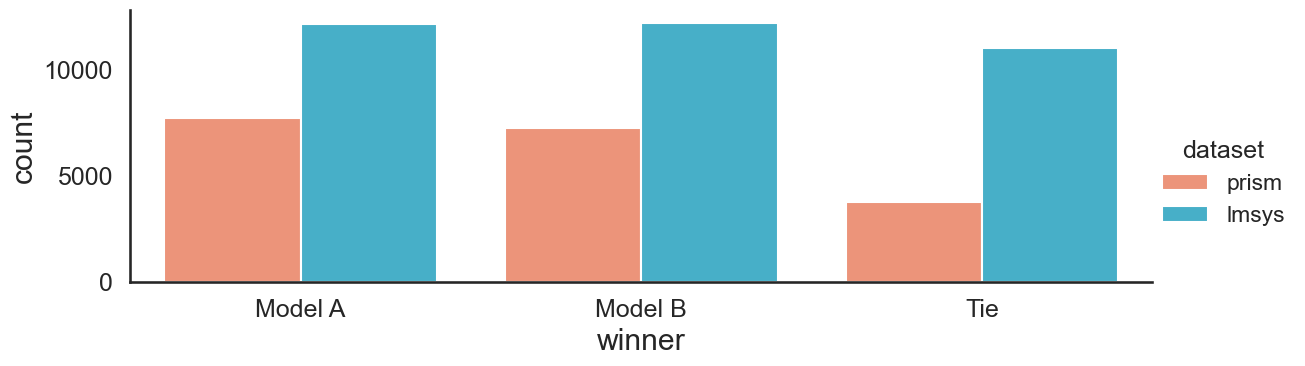

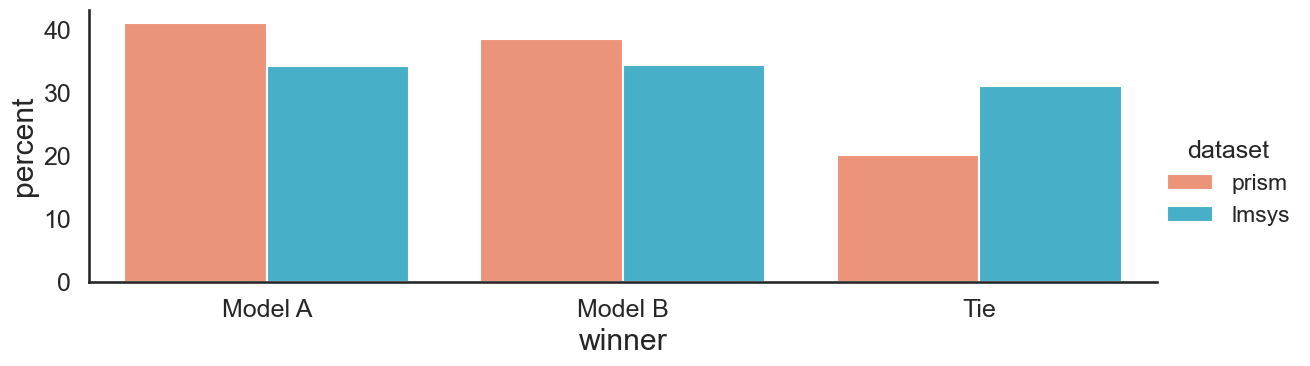

In [14]:
# Comparison plot by count
x, y = "winner", "dataset"
df = combined_battles.groupby(y)[x].value_counts()
df = df.rename("count").reset_index()
df = df.sort_values(by="dataset", ascending=False)
df["winner"] = df["winner"].map(lambda x: x.replace("_", " ").title())
sns.catplot(x=x, y="count", hue=y, kind="bar", data=df, height=4, aspect=3)
# Save
plt.savefig(f"{PLOT_PATH}/lmsys_count.pdf", bbox_inches="tight", format="pdf")
plt.show()

# Comparison plot by proportions
df1 = combined_battles.groupby(y)[x].value_counts(normalize=True)
df1 = df1.mul(100)
df1 = df1.rename("percent").reset_index()
df1["winner"] = df1["winner"].map(lambda x: x.replace("_", " ").title())
df1 = df1.sort_values(by="dataset", ascending=False)
sns.catplot(x=x, y="percent", hue=y, kind="bar", data=df1, height=4, aspect=3)
plt.savefig(f"{PLOT_PATH}/lmsys_pct.pdf", bbox_inches="tight", format="pdf")
plt.show()

### Win Rates

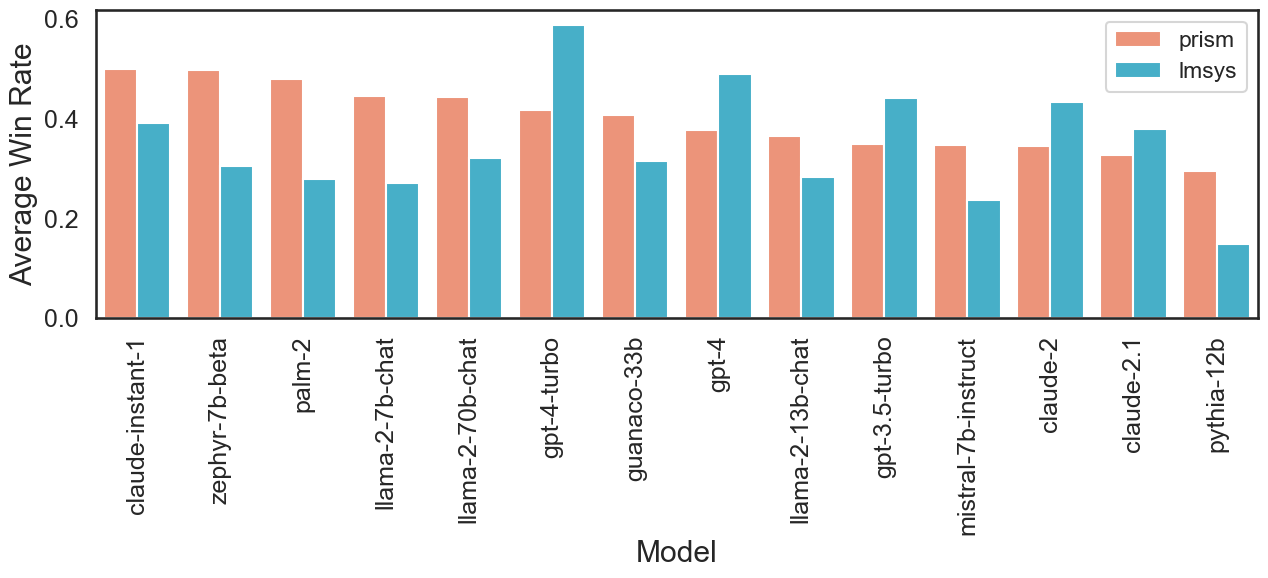

In [15]:
INCLUDE_TIES = True
limit_show_number = 21  # Max of our models (less than this are actually shared)
combined_win_rates = []
columns = []
for dataset in ["prism", "lmsys"]:
    if INCLUDE_TIES:
        specific_battles = combined_battles[combined_battles["dataset"] == dataset]
    else:
        specific_battles = combined_battles_no_ties[
            combined_battles_no_ties["dataset"] == dataset
        ]
    row_beats_col_freq = compute_pairwise_win_fraction(
        specific_battles, None, limit_show_number=limit_show_number
    )
    avg_win_rate = dict(row_beats_col_freq.mean(axis=1).sort_values(ascending=False))
    combined_win_rates.append(avg_win_rate)
    columns.append(dataset)


combined_win_df = pd.DataFrame.from_records(combined_win_rates).T
combined_win_df.columns = columns
unstacked_df = (
    combined_win_df.reset_index()
    .melt(
        id_vars=["index"],
        value_vars=["prism", "lmsys"],
        var_name="dataset",
        value_name="value",
    )
    .sort_values(by=["dataset", "value"], ascending=False)
)

plt.figure(figsize=(15, 4))
ax = sns.barplot(x="index", y="value", hue="dataset", data=unstacked_df)
# Move legend
plt.legend(loc="upper right")
plt.xticks(rotation=90)
plt.ylabel("Average Win Rate")
plt.xlabel("Model")
plt.show()

## Plot Win Rates

In [16]:
INCLUDE_TIES = True

# Win rates
limit_show_number = 21  # Max of our models (less than this are actually shared)
combined_win_rates = []
columns = []
for dataset in ["prism", "lmsys"]:
    if INCLUDE_TIES:
        specific_battles = combined_battles[combined_battles["dataset"] == dataset]
    else:
        specific_battles = combined_battles_no_ties[
            combined_battles_no_ties["dataset"] == dataset
        ]
    row_beats_col_freq = compute_pairwise_win_fraction(
        specific_battles, None, limit_show_number=limit_show_number
    )
    avg_win_rate = dict(row_beats_col_freq.mean(axis=1).sort_values(ascending=False))
    combined_win_rates.append(avg_win_rate)
    columns.append(dataset)

combined_win_df

,prism,lmsys
claude-instant-1,0.498593,0.391281
zephyr-7b-beta,0.497205,0.304659
palm-2,0.479830,0.278703
llama-2-7b-chat,0.445286,0.271165
llama-2-70b-chat,0.443740,0.320342
gpt-4-turbo,0.417920,0.587978
guanaco-33b,0.406831,0.315057
gpt-4,0.378015,0.488764
llama-2-13b-chat,0.365784,0.282535
gpt-3.5-turbo,0.349227,0.442117


In [17]:
order = combined_win_df["prism"].sort_values(ascending=False).index
print(order)

Index(['claude-instant-1', 'zephyr-7b-beta', 'palm-2', 'llama-2-7b-chat',
       'llama-2-70b-chat', 'gpt-4-turbo', 'guanaco-33b', 'gpt-4',
       'llama-2-13b-chat', 'gpt-3.5-turbo', 'mistral-7b-instruct', 'claude-2',
       'claude-2.1', 'pythia-12b'],
      dtype='object')


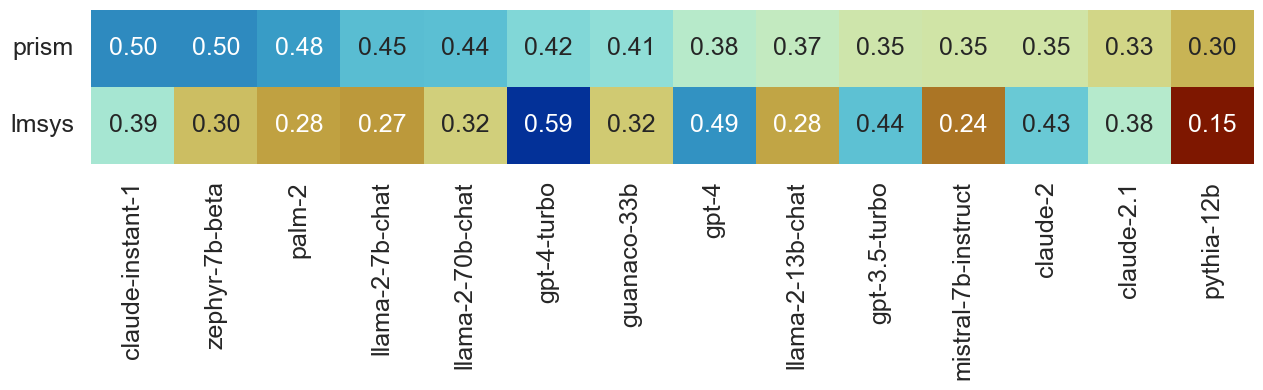

In [18]:
# Plot pairwise win frequency heatmap
fig, ax = plt.subplots(1, 1, figsize=(15, 2))
sns.heatmap(
    combined_win_df.T,
    annot=True,
    fmt=".2f",
    ax=ax,
    cmap=palettes_dict["roma"],
    cbar=False,
)
# Keep y axis no rotation
plt.yticks(rotation=0)
plt.savefig(f"{PLOT_PATH}/lmsys_win_rates.pdf", bbox_inches="tight", format="pdf")
plt.show()

## Control for Dataset Differences

In [19]:
# Find pairs of [model_a, model_b] or [model_b, model_a]
combined_battles["pair_list"] = combined_battles.apply(
    lambda x: sorted([x["model_a"], x["model_b"]]), axis=1
)
combined_battles["pair_string"] = combined_battles["pair_list"].map(
    lambda x: f"{str(x[0])}vs{str(x[1])}"
)

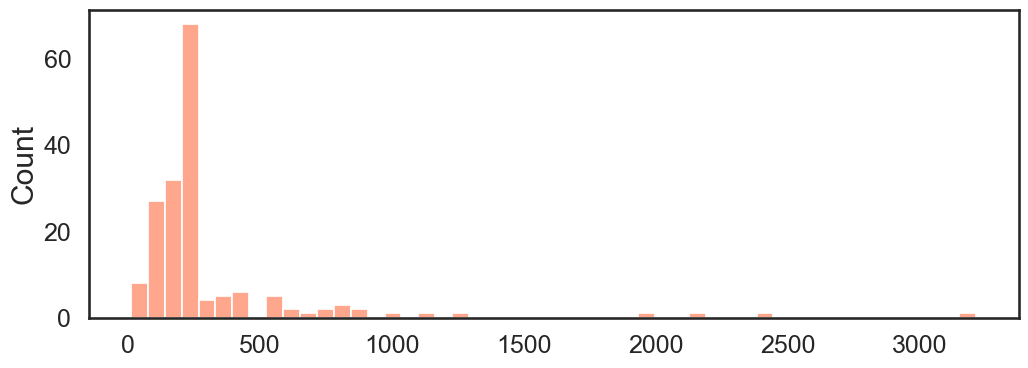

LQ: 170.25
10th percentile: 114.0
20th percentile: 137.40000000000003
30th percentile: 194.3
40th percentile: 207.0
50th percentile: 217.0
60th percentile: 227.6
70th percentile: 241.0
80th percentile: 307.60000000000025
90th percentile: 563.0000000000001
5th percentile: 85.60000000000001


In [20]:
# Plot distribution
sns.histplot(combined_battles.groupby(["dataset", "pair_string"]).size(), bins=50)
plt.show()

# LQ
lq = combined_battles.groupby(["dataset", "pair_string"]).size().quantile(0.25)
print(f"LQ: {lq}")

# Print deciles
for i in range(1, 10):
    q = combined_battles.groupby(["dataset", "pair_string"]).size().quantile(i / 10)
    print(f"{i}0th percentile: {q}")

# And 95th percentile
q = combined_battles.groupby(["dataset", "pair_string"]).size().quantile(0.05)
print(f"5th percentile: {q}")

Number of pairs in LMSYS: 81
Min pair: gpt-3.5-turbovspythia-12b
Size of min pair: 13


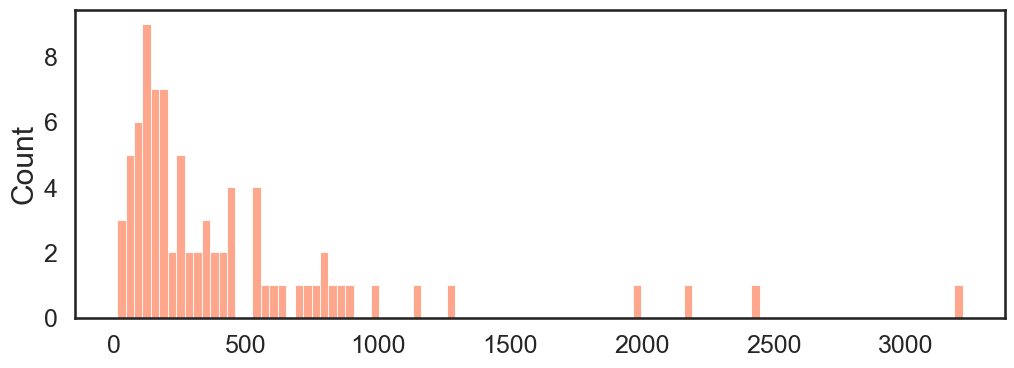

count      81.000000
mean      436.530864
std       546.505377
min        13.000000
25%       133.000000
50%       252.000000
75%       539.000000
max      3214.000000
dtype: float64

In [21]:
# Let's just look at LMSYS
lmsys = combined_battles[combined_battles["dataset"] == "lmsys"]
groups = lmsys.groupby("pair_string").size()
print(f"Number of pairs in LMSYS: {len(groups)}")
# Find smallest pair
min_pair = groups.idxmin()
print(f"Min pair: {min_pair}")
# Size of pair
print(f"Size of min pair: {groups[min_pair]}")

# Show distribution
sns.histplot(groups, bins=100)
plt.show()
# Describe size
groups.describe()

In [22]:
# Find threshold for 90% of data having more than this number of pair appearances
p10 = groups.quantile(0.1)
print(f"90th percentile: {p10}")

90th percentile: 79.0


In [23]:
# Find top 10 smallest pairs
top_10 = groups.sort_values(ascending=True).head(10)
print(top_10)

pair_string
gpt-3.5-turbovspythia-12b       13
gpt-4vspythia-12b               18
llama-2-7b-chatvspythia-12b     37
claude-2vspythia-12b            51
llama-2-13b-chatvspythia-12b    53
gpt-4-turbovspalm-2             63
guanaco-33bvsllama-2-7b-chat    71
claude-2.1vspalm-2              72
mistral-7b-instructvspalm-2     79
claude-2vsguanaco-33b           91
dtype: int64


In [24]:
# Now let's look at just PRISM
prism = combined_battles[combined_battles["dataset"] == "prism"]
groups = prism.groupby("pair_string").size()
print(f"Number of pairs in PRISM: {len(groups)}")
# Find smallest pair
min_pair = groups.idxmin()
print(f"Min pair: {min_pair}")
# Size of pair
print(f"Size of min pair: {groups[min_pair]}")
# Describe size
groups.describe()

Number of pairs in PRISM: 91
Min pair: gpt-4vsllama-2-13b-chat
Size of min pair: 107


count     91.000000
mean     206.131868
std       39.232132
min      107.000000
25%      197.500000
50%      216.000000
75%      233.000000
max      259.000000
dtype: float64

In [25]:
# Find battles pairs which appear in both prism and lmsys
prism_pairs = set(prism["pair_string"])
lmsys_pairs = set(lmsys["pair_string"])
common_pairs = prism_pairs.intersection(lmsys_pairs)
print(f"Common pairs: {len(common_pairs)}")

Common pairs: 81


In [26]:
# Subset combined battles
filtered_battles = combined_battles[combined_battles["pair_string"].isin(common_pairs)]

## Bootstrapped Rank Centrality

In [27]:
# Sample the same number of battles
SAMPLE_EVEN = True
INCLUDE_TIES = True
BOOTSTRAP_ROUNDS = 1000

if INCLUDE_TIES:
    filtered_battles = combined_battles[
        combined_battles["pair_string"].isin(common_pairs)
    ]
else:
    filtered_battles = combined_battles_no_ties[
        combined_battles_no_ties["pair_string"].isin(common_pairs)
    ]

combined_scores = []
for dataset in ["prism", "lmsys"]:
    specific_battles = filtered_battles[filtered_battles["dataset"] == dataset]
    for bs in range(BOOTSTRAP_ROUNDS):
        if SAMPLE_EVEN:
            # Set up the sampling slots (as approx 90th percentile)
            n_slots_per_battle = 80
            # Sample n battles
            groups = specific_battles.groupby(["pair_string"], as_index=False)
            # Sample with replacement
            resampled = groups.apply(
                lambda grp: grp.sample(n_slots_per_battle, replace=True),
                include_groups=False,
            ).reset_index(drop=True)
            # Compute the scores over these battles
            scores = compute_rank_centrality(resampled)
        else:
            resampled = specific_battles.sample(frac=1.0, replace=True)
            scores = compute_rank_centrality(specific_battles)

        df = pd.Series(scores, name=f"{dataset}")
        combined_scores.append(df)

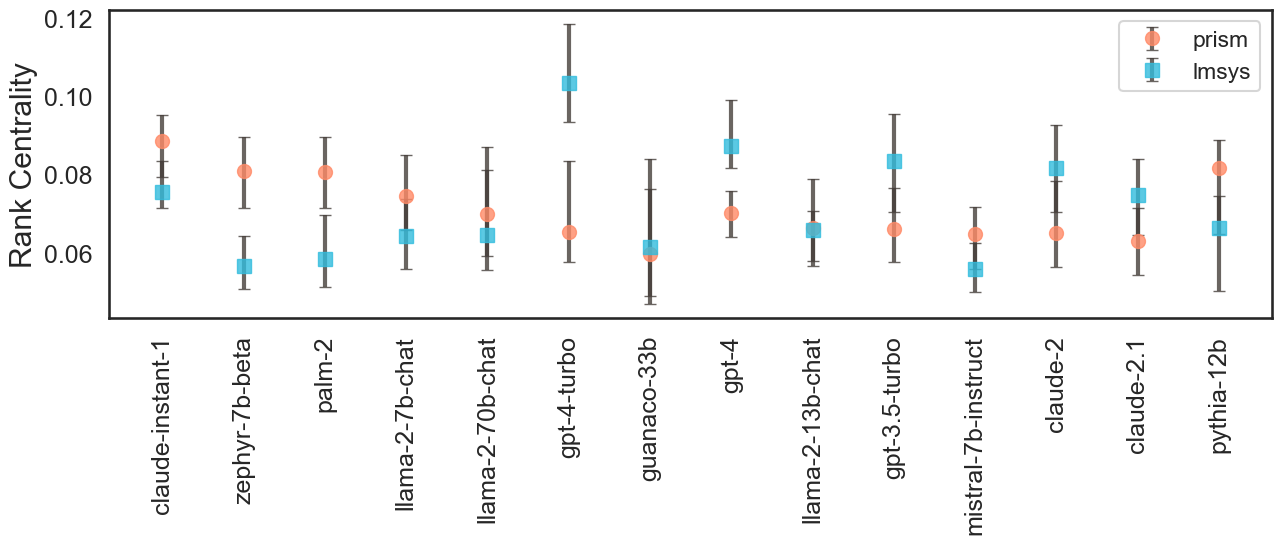

In [28]:
# Combine bootstraps
bs_df = pd.concat(combined_scores, axis=1)

# Set up fig
fig, ax = plt.subplots(1, 1, figsize=(15, 4))
markers = ["o", "s"]

# Loop through (this code is like LMSYS implementation of bootstrapped ELO)
frames = []
for i, dataset in enumerate(["prism", "lmsys"]):
    plot_df = bs_df[dataset].copy()
    plot_df["rating"] = plot_df.median(axis=1)
    plot_df["lower"] = plot_df.quantile(0.05, axis=1)
    plot_df["upper"] = plot_df.quantile(0.95, axis=1)
    plot_df["model"] = plot_df.index
    plot_df["dataset"] = dataset

    bars = plot_df.copy()
    # Sort into a common order (same as previous plot)
    bars = bars.loc[order]
    ax.errorbar(
        bars["model"],
        bars["rating"],
        yerr=[bars["rating"] - bars["lower"], bars["upper"] - bars["rating"]],
        ecolor=basic_colors_dict["darkgrey"],
        elinewidth=3,
        fmt=markers[i],
        capsize=4,
        alpha=0.8,
        label=bars["dataset"].iloc[0],
        markersize=10,
    )

# Plot tweaks
plt.legend()
plt.xlabel("")
plt.ylabel("Rank Centrality")
plt.xticks(rotation=90)
# Save
plt.savefig(f"{PLOT_PATH}/lmsys_bootstrap.pdf", bbox_inches="tight", format="pdf")
plt.show()